In [1]:
from pscore_data_reader_preproc import read_and_process_data, model_evaluation
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read in the data using the pre-processing code
x_train, y_train, x_test, y_test, train_team_values, test_team_values = read_and_process_data(
     r"E:\github_repos\Private_Projects\NCAA_FBS_AP_Ranking_Predictions\python_ap\scripts_and_data\data\score_pred_train_data.csv",
     r"E:\github_repos\Private_Projects\NCAA_FBS_AP_Ranking_Predictions\python_ap\scripts_and_data\data\score_pred_test_data.csv",
     True
)

# check to make sure the data looks right
x_train.shape
x_test.shape

train data has shape: (14648, 490)
test data has shape: (132, 490)


(132, 490)

In [3]:
# Step 1: Define hyperparameter grid
learning_rate_values = [0.01, 0.1, 0.2]
n_estimators_values = [50, 100, 200]
max_depth_values = [3, 5, 7]

# Step 2: Create the parameter grid
gb_param_grid = {
    'learning_rate': learning_rate_values,
    'n_estimators': n_estimators_values,
    'max_depth': max_depth_values
}

# Step 3: set up regressor
gb_regressor_model = GradientBoostingRegressor()

# Step 4: fit the grid search model
gb_grid_search = GridSearchCV(
    estimator=gb_regressor_model,
    param_grid=gb_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Use negative MSE as the scoring metric
    n_jobs=-3,  # Use all but 2 available cores
    verbose=1  # Output progress
)

In [4]:
# fit the grid search
gb_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-3,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

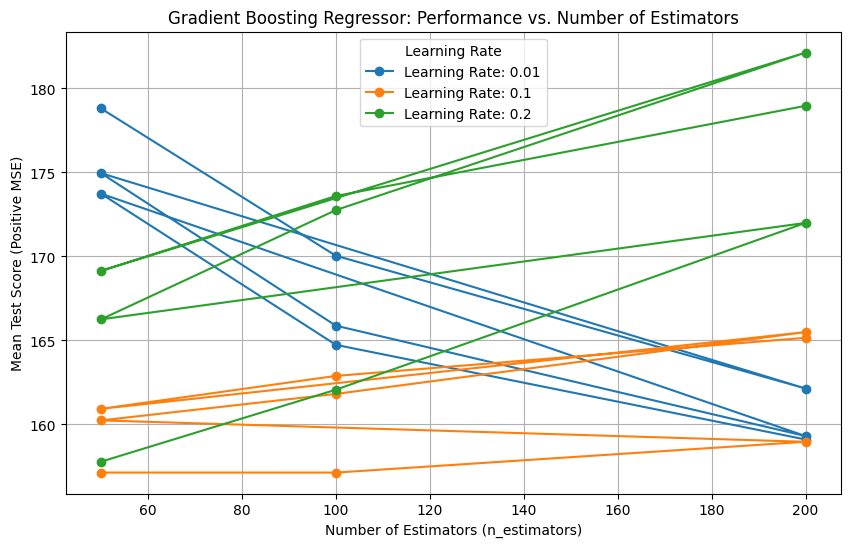

In [5]:
# Extract results from GridSearchCV
gb_results = pd.DataFrame(gb_grid_search.cv_results_)

# Plot performance for different learning_rate values grouped by n_estimators
plt.figure(figsize=(10, 6))

for lr in learning_rate_values:  # learning_rate_values: [0.01, 0.1, 0.2]
    subset = gb_results[gb_results['param_learning_rate'] == lr]
    plt.plot(
        subset['param_n_estimators'],
        -subset['mean_test_score'],  # Convert Negative MSE to Positive MSE
        marker='o',
        label=f'Learning Rate: {lr}'
    )

# Customize the plot
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Mean Test Score (Positive MSE)')
plt.title('Gradient Boosting Regressor: Performance vs. Number of Estimators')
plt.legend(title='Learning Rate')
plt.grid()
plt.show()

In [6]:
# Get the best parameters from GridSearchCV
best_n_estimators_value = gb_grid_search.best_params_['n_estimators']
best_max_depth_value = gb_grid_search.best_params_['max_depth']
best_learning_rate_value = gb_grid_search.best_params_['learning_rate']

# Print the best values
print(f"Best n_estimators: {best_n_estimators_value}")
print(f"Best max_depth: {best_max_depth_value}")
print(f"Best learning_rate: {best_learning_rate_value}")

Best n_estimators: 100
Best max_depth: 3
Best learning_rate: 0.1


In [7]:
# Fit the final model using the best parameters from GridSearchCV
best_gb_regressor = GradientBoostingRegressor(
    n_estimators=best_n_estimators_value,
    max_depth=best_max_depth_value,
    learning_rate=best_learning_rate_value
)

# Train the model on the training data
best_gb_regressor.fit(x_train, y_train)

GradientBoostingRegressor()

In [8]:
# Model evaluation
y_pred_train = best_gb_regressor.predict(x_train)

# evaluate model
model_evaluation(y_train, y_pred_train)

R-squared: 0.302
Mean Squared Error (MSE): 136.372
Mean Absolute Error (MAE): 9.408
